In [ ]:
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
    calc_covariance,
    cov_to_vols,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

# testing

# Plot

In [ ]:
dict_groups = {
    "Long Only": ["L-CDS-EW", "L-CDS-IV", "L-FX-EW", "L-FX-IV"],
    "Long Short Ativo": [
        "L-CDS-S-FX-EW",
        "L-CDS-S-FX-IV-BN",
        "L-CDS-S-FX-IV",
        "L-FX-S-CDS-EW",
        "L-FX-S-CDS-IV-BN",
        "L-FX-S-CDS-IV",
    ],
    "Long Short Pares": [
        "LS-CDS_FX-BN-BRL",
        "LS-CDS_FX-IV-BRL",
        "LS-CDS_FX-BN-CLP",
        "LS-CDS_FX-IV-CLP",
        "LS-CDS_FX-BN-CNY",
        "LS-CDS_FX-IV-CNY",
        "LS-CDS_FX-BN-COP",
        "LS-CDS_FX-IV-COP",
        "LS-CDS_FX-BN-IDR",
        "LS-CDS_FX-IV-IDR",
        "LS-CDS_FX-BN-MXN",
        "LS-CDS_FX-IV-MXN",
        "LS-CDS_FX-BN-RUB",
        "LS-CDS_FX-IV-RUB",
        "LS-CDS_FX-BN-TRY",
        "LS-CDS_FX-IV-TRY",
        "LS-CDS_FX-BN-ZAR",
        "LS-CDS_FX-IV-ZAR",
    ],
    "Long Short Classe": [
        "LS-CDS-FX-BN-IV",
        "LS-CDS-FX-IV",
        "LS-FX-CDS-BN-IV",
        "LS-FX-CDS-IV",
    ],
    "Timeseries Momentum": [
        "TSMOM-3",
        "TSMOM-6",
        "TSMOM-12",
        "TSMOM-CDS-12",
        "TSMOM-CDS-3",
        "TSMOM-CDS-6",
        "TSMOM-FX-12",
        "TSMOM-FX-3",
        "TSMOM-FX-6",
    ],
    "Valor": [
        "VALUE-CDS-PAIRED",
        "VALUE-FX-PAIRED",
    ],
    "Cross-Sectional Momentum": [
        "XSMOM-CDS",
        "XSMOM-FX",
        "XSMOM",
    ],
}

In [219]:
FOLDER = Path(
    "C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests"
)


list_series = []


for file_path in FOLDER.glob("*.xlsx"):


    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]


    s_backtest.name = file_path.stem

    list_series.append(s_backtest)


df_backtest = pd.concat(list_series, axis=1).sort_index(ascending=True)
df_backtest

,L-CDS-EW,L-CDS-IV,L-CDS-S-FX-EW,L-CDS-S-FX-IV-BN,L-CDS-S-FX-IV,L-FX-EW,L-FX-IV,L-FX-S-CDS-EW,L-FX-S-CDS-IV-BN,L-FX-S-CDS-IV,...,TSMOM-CDS-3,TSMOM-CDS-6,TSMOM-FX-12,TSMOM-FX-3,TSMOM-FX-6,VALUE-CDS-PAIRED,VALUE-FX-PAIRED,XSMOM-CDS,XSMOM-FX,XSMOM
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-03,120.245999,171.532717,155.631476,133.367551,233.621132,231.746935,194.497392,82.986356,44.183286,55.745857,...,138.408740,129.158926,190.331371,395.422789,303.625063,179.254115,164.614583,171.315647,85.043284,130.649615
2024-09-04,120.281403,171.521293,155.280055,133.138540,232.839900,232.253380,195.045363,83.174221,44.316222,55.932786,...,138.190879,129.108272,191.386401,395.982749,304.370362,179.539967,164.799510,171.408273,84.878939,130.561994
2024-09-05,120.382861,171.643776,155.262797,133.079096,232.443245,232.463852,195.465891,83.184009,44.378092,56.028547,...,138.250503,129.234202,192.730907,398.246031,305.810981,178.899320,165.785035,171.634485,85.147261,130.990343


In [ ]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Dissertação Mestrado\Analysis")

data = np.log(df_backtest.dropna(how="all")).diff(1).cumsum()
title = "Teste"
columns = data.columns[:10]


def plot_trackers_returns(
    data, title, columns, palette="tab10", figsize=(5, 3), y_label="Log-Retorno"
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)

    sns.lineplot(data=data[columns], palette=palette, linewidth=1, dashes=False)

    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5), fontsize=8, frameon=False)

    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.00%}"))

    plt.grid(True, linestyle="--", linewidth=0.7)

    plt.xlabel(None)
    plt.ylabel(y_label, fontsize=8)
    plt.gca().yaxis.set_label_position("right")

    plt.xlim(data.dropna(how="all").index.min(), data.dropna(how="all").index.max())

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tick_params("both", length=0)

    plt.title(title, fontsize=10, fontweight="bold")

    plt.savefig(OUTPUT_FOLDER.joinpath(f"{title}.svg"), bbox_inches="tight")
    plt.show()

In [ ]:
for group, columns in dict_groups.items():
    plot_trackers_returns(data[columns], group, columns)

In [ ]:
trackers.columns

In [ ]:
trackers.filter(like="fx").rename(lambda col: col[:3], axis=1)

In [ ]:
from run_backtest import trackers

_df = np.exp(
    np.log(
        trackers.filter(like="fx").rename(lambda col: col[:3], axis=1).dropna(how="all")
    )
    .diff(1)
    .cumsum()
)
plot_trackers_returns(
    _df, "FX Trackers", _df.columns, palette="tab20", figsize=(10, 6), y_label="Retorno"
)
_df = np.exp(
    np.log(
        trackers.filter(like="cds")
        .rename(lambda col: col[:3], axis=1)
        .dropna(how="all")
    )
    .diff(1)
    .cumsum()
)
plot_trackers_returns(
    _df,
    "CDS Trackers",
    _df.columns,
    palette="tab20",
    figsize=(10, 6),
    y_label="Retorno",
)

In [235]:
def calculate_rolling_sharpe_ratio(log_returns):
    numerator = log_returns.rolling(window=252).sum()
    denominator = log_returns.rolling(window=252).std() * (252 ** (0.5))
    return (numerator / denominator).rolling(window=252).mean()

In [244]:
_ = 1000.123
f"{_:.2f}"

'1000.12'

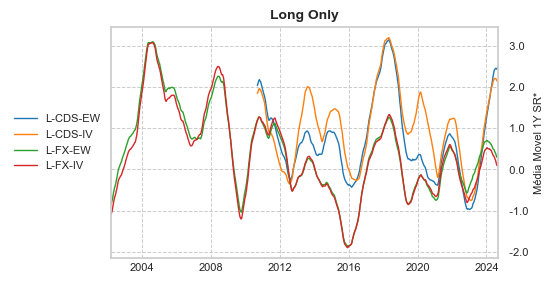

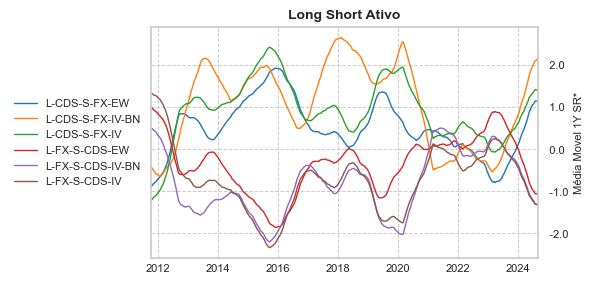

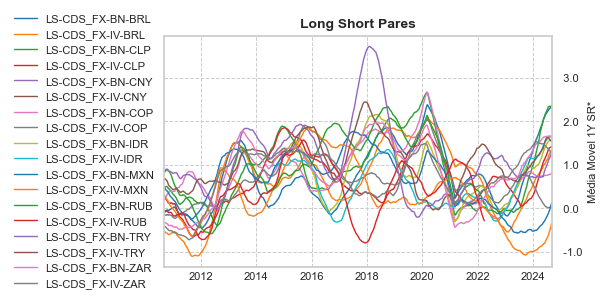

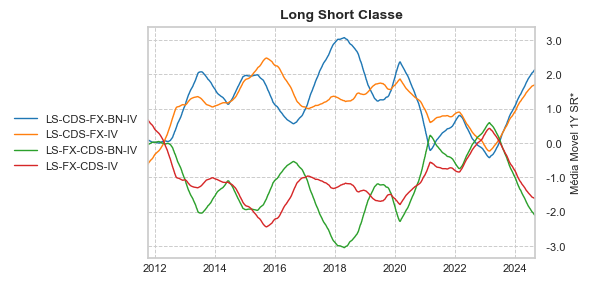

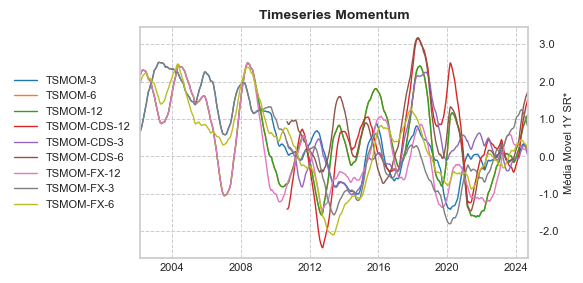

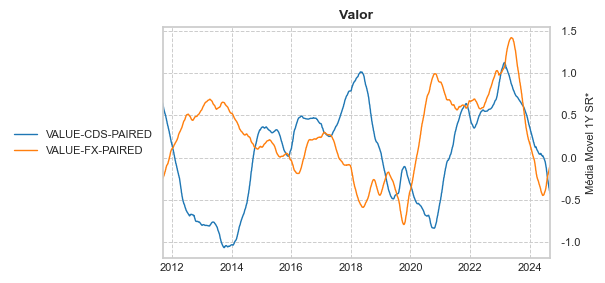

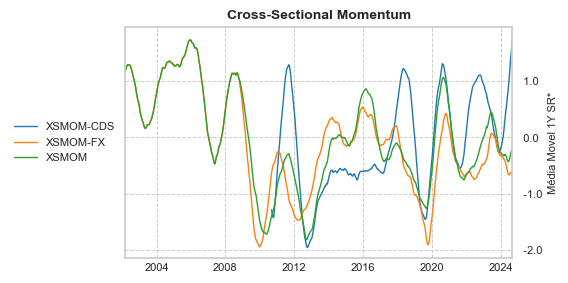

In [246]:
def plot_rolling_sharpe_ratio(
    data, title, columns, palette="tab10", figsize=(5, 3), y_label="Média Movel 1Y SR*"
):
    plt.rcParams["font.family"] = "Calibri"
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=figsize)

    sns.lineplot(data=data[columns], palette=palette, linewidth=1, dashes=False)

    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5), fontsize=8, frameon=False)

    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"  {y:.1f}"))

    plt.grid(True, linestyle="--", linewidth=0.7)

    plt.xlabel(None)
    plt.ylabel(y_label, fontsize=8)
    plt.gca().yaxis.set_label_position("right")

    plt.xlim(data.dropna(how="all").index.min(), data.dropna(how="all").index.max())

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tick_params("both", length=0)

    plt.title(title, fontsize=10, fontweight="bold")

    plt.savefig(
        OUTPUT_FOLDER.joinpath(f"{title}_rolling_sharpe.svg"),
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

for group, columns in dict_groups.items():
    plot_rolling_sharpe_ratio(
        calculate_rolling_sharpe_ratio(data[columns].diff(1)), group, columns
    )

In [214]:
data

,L-CDS-EW,L-CDS-IV,L-CDS-S-FX-EW,L-CDS-S-FX-IV-BN,L-CDS-S-FX-IV,L-FX-EW,L-FX-IV,L-FX-S-CDS-EW,L-FX-S-CDS-IV-BN,L-FX-S-CDS-IV,...,TSMOM-CDS-3,TSMOM-CDS-6,TSMOM-FX-12,TSMOM-FX-3,TSMOM-FX-6,VALUE-CDS-PAIRED,VALUE-FX-PAIRED,XSMOM-CDS,XSMOM-FX,XSMOM
date,,,,,,,,,,,,,,,,,,,,,
2000-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-15,NaN,NaN,NaN,NaN,NaN,0.001117,0.001261,NaN,NaN,NaN,...,NaN,NaN,-0.002767,-0.001475,0.001261,NaN,NaN,NaN,-0.002291,-0.002291
2000-02-16,NaN,NaN,NaN,NaN,NaN,0.001431,0.000355,NaN,NaN,NaN,...,NaN,NaN,0.003040,0.005293,0.000355,NaN,NaN,NaN,0.001580,0.001580
2000-02-17,NaN,NaN,NaN,NaN,NaN,0.003170,0.001616,NaN,NaN,NaN,...,NaN,NaN,0.001668,0.006034,0.001616,NaN,NaN,NaN,-0.000386,-0.000386
2000-02-18,NaN,NaN,NaN,NaN,NaN,0.002726,0.001430,NaN,NaN,NaN,...,NaN,NaN,0.003024,0.006993,0.001430,NaN,NaN,NaN,0.001461,0.001461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.196617,0.531035,0.502020,0.577308,0.875418,0.770478,0.589837,-0.322856,-0.679424,-0.669063,...,0.335536,0.442447,0.538711,1.284853,1.053970,0.589385,0.476560,0.466156,-0.376630,0.009492
2024-09-03,0.193659,0.527391,0.503482,0.577669,0.879863,0.766430,0.582678,-0.324535,-0.682086,-0.673890,...,0.332562,0.438717,0.554114,1.282956,1.066052,0.585858,0.477008,0.463831,-0.363794,0.024208
2024-09-04,0.193954,0.527324,0.501096,0.575915,0.876279,0.768613,0.585491,-0.322149,-0.678992,-0.670309,...,0.330987,0.438325,0.559642,1.284371,1.068503,0.587451,0.478130,0.464371,-0.365728,0.023537


In [233]:
df = data[columns]
log_returns = df.diff(1)
numerator = log_returns.rolling(window=252).sum()


df

,XSMOM-CDS,XSMOM-FX,XSMOM
date,,,
2000-02-14,NaN,NaN,NaN
2000-02-15,NaN,-0.002291,-0.002291
2000-02-16,NaN,0.001580,0.001580
2000-02-17,NaN,-0.000386,-0.000386
2000-02-18,NaN,0.001461,0.001461
...,...,...,...
2024-08-30,0.466156,-0.376630,0.009492
2024-09-03,0.463831,-0.363794,0.024208
2024-09-04,0.464371,-0.365728,0.023537
